In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import pandas as pd 

from cartpole import  optimization_problem, state_defects, minimize, objective, numba


In [51]:
# Define the initial and final states 
x0 = [0.0, 0.0, 0.0, 0.0]  # initial position and velocity
xf = [1, np.pi, 0.0, 0.0]  # final position and velocity
states_dim = 4
N = 45
T = 2 # make dimentionless, to make dt as opt param

# Define the number of time steps
t = np.linspace(0, T, N+1)  # time grid
dt = t[1] - t[0]  # time step
#bounds
u_b = 5
l_b = -5
# Define the constants
params =(N,states_dim,dt, u_b, l_b)

In [52]:
# result = optimization_problem(x0, xf, params)

N = params[0] 
states_dim = params[1] 
dt = params[2]
u_b = params[3]
l_b = params[4]
u_init = np.zeros(N)
u_init = u_init

# Initial guess for states
x_init = np.zeros((N+1, states_dim))
x_init[:, 0] = np.linspace(x0[0], xf[0], N+1)
x_init[:, 1] = np.linspace(0, np.pi, N+1)
# Concatenate control inputs and states into a single decision variable
initial_guess = np.concatenate([u_init, x_init.flatten()])

In [53]:
u_init

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [54]:
@numba.njit
def jacobian(decision_variables, args):
    N = args[0] 
    jac = np.zeros_like(decision_variables)
    # Index [N -1] in the decision_variables vector contains the state  
    u = decision_variables[:N]
    jac[:N] = (2*u) # deriv of objective 
    return jac

In [55]:


# Define the optimization problem
@numba.jit
def problem(decision_variables, args):
    N = args[0] 
    u = decision_variables[:N]

    obj_value = objective(u)

    return obj_value

# Define the bounds for the decision variables
bounds = [(-20, 20)] * N 
num_state_bounds = states_dim*(N+1)

state_bounds = [(None, None)] * num_state_bounds

for i in range(0,N+1):
    state_bounds[states_dim*i] = (l_b,u_b)

bounds = bounds + state_bounds    
#Enforcing Bound constraint on initial and final states
bounds[N] = (0.0,0.0)
bounds[N+1] = (0.0,0.0)
bounds[N+2] = (0.0, 0.0)
bounds[N +3] = (0.0, 0.0)
# Final Bounds
bounds[N+ num_state_bounds - states_dim + 0] = (1.0,1.0)
bounds[N+ num_state_bounds - states_dim + 1] = (np.pi,np.pi)
bounds[N+ num_state_bounds - states_dim + 2] = (0.0,0.0)
bounds[N+ num_state_bounds - states_dim + 3] = (0.0,0.0)
arguments = (params,)
# Define the constraints
constraints = [{'type': 'eq', 'fun': state_defects, 'args':arguments },]
# Solve the optimization problem
result = minimize(problem, initial_guess, method='SLSQP', bounds=bounds, args=arguments, constraints=constraints)

In [56]:
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1336.7407793752866
       x: [ 1.464e+00  4.013e+00 ...  0.000e+00  0.000e+00]
     nit: 26
     jac: [ 2.927e+00  8.025e+00 ...        nan        nan]
    nfev: 5786
    njev: 26

In [57]:
n = len(initial_guess)

In [58]:
# Extract the optimal control inputs and states

u_opt = result.x[:N]
x_opt = result.x[N:].reshape((N+1, states_dim))
#x_p = result.x * multiplier
#u_opt = x_p[:N]
#x_opt = x_p[N:].reshape((N+1, states_dim))

# Print the optimal control inputs and states
# print("Optimal control inputs:")
# print(u_opt)
# print("Optimal states:")
# print(x_opt)


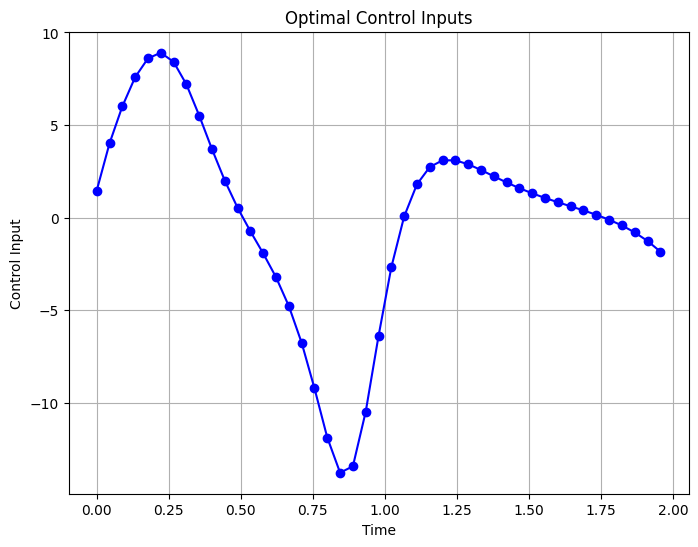

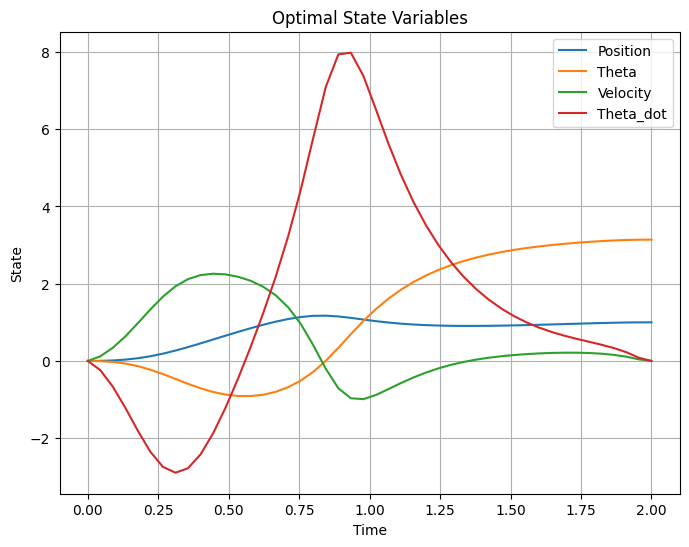

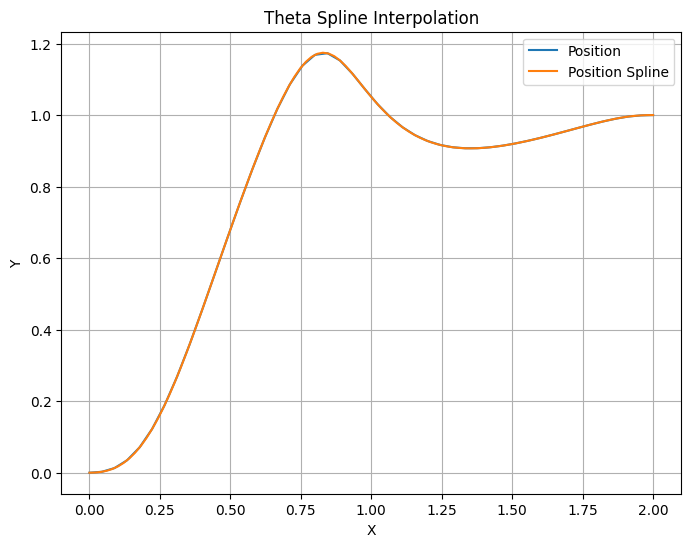

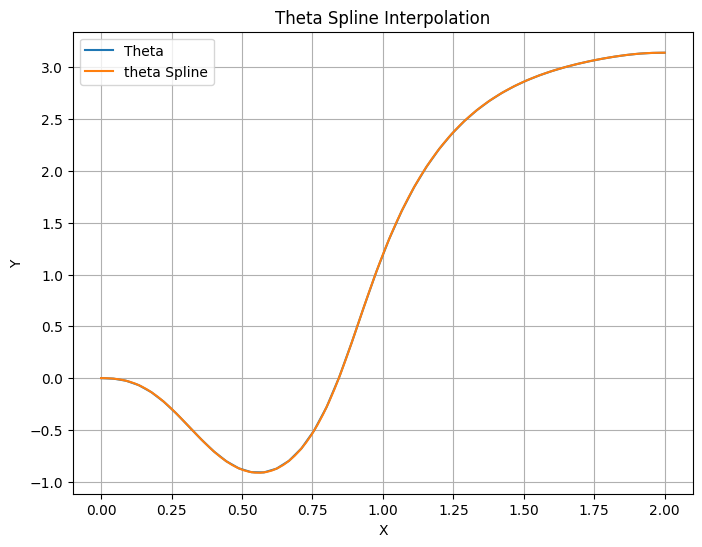

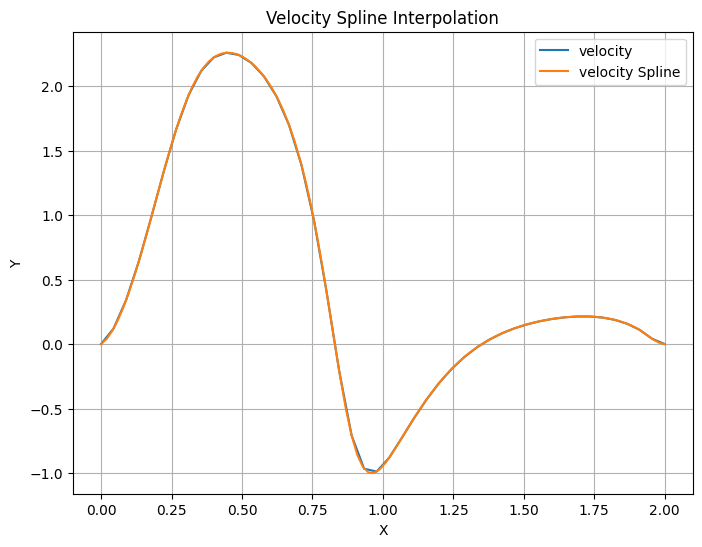

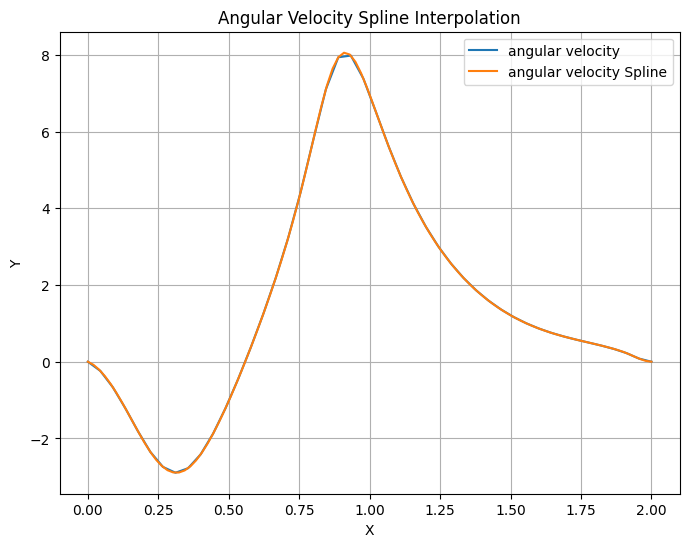

In [59]:

# Plotting control variables
plt.figure(figsize=(8, 6))
plt.plot(t[:-1], u_opt, 'bo-')
plt.xlabel('Time')
plt.ylabel('Control Input')
plt.title('Optimal Control Inputs')
plt.grid(True)
plt.show()

df = pd.DataFrame(u_opt)  

# Export the DataFrame to a CSV file
#df.to_csv('control_data.csv', index=False)


# Plotting state variables
t_ = np.linspace(0, T, N+1)  # time grid

plt.figure(figsize=(8, 6))
plt.plot(t_, x_opt[:, 0], label='Position')
plt.plot(t_, x_opt[:, 1], label='Theta')
plt.plot(t_, x_opt[:, 2], label='Velocity')
plt.plot(t_, x_opt[:, 3], label='Theta_dot')
plt.xlabel('Time')
plt.ylabel('State')
plt.title('Optimal State Variables')
plt.legend()
plt.grid(True)
plt.show()

cs = CubicSpline(t_, x_opt[:, 0])

# Generate values for plotting
x_plot = np.linspace(0, 2, 100)
y_plot = cs(x_plot)

# Plot the cubic spline
plt.figure(figsize=(8, 6))
plt.plot(t_, x_opt[:, 0], label='Position')
plt.plot(x_plot, y_plot, label='Position Spline')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Theta Spline Interpolation')
plt.legend()
plt.grid(True)
plt.show()
# Create a DataFrame from the spline data
df = pd.DataFrame(y_plot)  

# Export the DataFrame to a CSV file
#df.to_csv('pos_spline_data.csv', index=False)


cs = CubicSpline(t_, x_opt[:, 1])
x_plot = np.linspace(0, 2, 100)
y_plot = cs(x_plot)

# Plot the cubic spline
plt.figure(figsize=(8, 6))
plt.plot(t_, x_opt[:, 1], label='Theta')
plt.plot(x_plot, y_plot, label='theta Spline')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Theta Spline Interpolation')
plt.legend()
plt.grid(True)
plt.show()

df = pd.DataFrame(y_plot, columns=['t'])  

# Export the DataFrame to a CSV file
#df.to_csv('theta_spline_data.csv', index=False)

cs = CubicSpline(t_, x_opt[:, 2])
x_plot = np.linspace(0, 2, 100)
y_plot = cs(x_plot)

# Plot the cubic spline
plt.figure(figsize=(8, 6))
plt.plot(t_, x_opt[:, 2], label='velocity')
plt.plot(x_plot, y_plot, label='velocity Spline')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Velocity Spline Interpolation')
plt.legend()
plt.grid(True)
plt.show()

df = pd.DataFrame(y_plot)  

# Export the DataFrame to a CSV file
# df.to_csv('velocity_spline_data.csv', index=False)

cs = CubicSpline(t_, x_opt[:, 3])
x_plot = np.linspace(0, 2, 100)
y_plot = cs(x_plot)

# Plot the cubic spline
plt.figure(figsize=(8, 6))
plt.plot(t_, x_opt[:, 3], label='angular velocity')
plt.plot(x_plot, y_plot, label='angular velocity Spline')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Angular Velocity Spline Interpolation')
plt.legend()
plt.grid(True)
plt.show()

df = pd.DataFrame(y_plot)  

# Export the DataFrame to a CSV file
#df.to_csv('angular_velocity_spline_data.csv', index=False)
